In [1]:
# dependencies import
from common_dependencies import *
from typing import NamedTuple
import model_versions as mv
import logging
logger = logging.getLogger(f'main.model_train')
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)
np.random.seed(290)
DataCrop = NamedTuple("DataCrop", [('left', int), ('top', int), ('width', int), ('height', int)])
DatasetPartDescription = NamedTuple("DatasetPartDescription", [('run_name', str), ('data_crop', DataCrop), ('crop_step', int)])

2024-04-09 17:19:25.361752: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: FFT
2024-04-09 17:19:25.401464: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 17:19:25.891711: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: DNN


In [2]:
# train params that can be easily changed
# paths for files with original data
PATH_TO_DATA = {
    'run_1': 
        ('data/original_data/run_1/run1_WM32_data.csv',
        'data/original_data/run_1/run1_WM32_defects.csv',
        'data/original_data/run_1/run1_WM32_pipe.csv'),
    'run_2':
        ('data/original_data/run_2/run2_WM32_data.csv',
        'data/original_data/run_2/run2_WM32_defects.csv',
        'data/original_data/run_2/run2_WM32_pipe.csv')
}

CROP_SIZE = 16
XSHIFT = 200
#CROP_STEP = 4

MAX_VAL = 1000

train_dataset_desc = (DatasetPartDescription('run_1', DataCrop(100,0,270,MAX_VAL), 1),)

val_dataset = (DatasetPartDescription('run_2', DataCrop(0,0,MAX_VAL,40), 1),)

In [3]:
def get_dataset_gen(path_to_data_tuple: tuple(),
                x_shift: int,
                data_part: DataCrop,
                crop_size: int, 
                crop_step: int):
    logger.debug("start")
    
    x_df, y_df = dw.get_x_and_y_data(*path_to_data_tuple)
    x_df = dw.roll_df(x_df, x_shift, 1)
    y_df = dw.roll_df(y_df, x_shift, 1)

    x_df = x_df.iloc[data_part.top:data_part.top+data_part.height, data_part.left:data_part.left+data_part.width]
    y_df = y_df.iloc[data_part.top:data_part.top+data_part.height, data_part.left:data_part.left+data_part.width]
    
    x_df = dw.extend_df_for_crops_dividing(x_df, crop_size, crop_step)
    y_df = dw.extend_df_for_crops_dividing(y_df, crop_size, crop_step)

    x_arr = dw.df_to_numpy(x_df)
    y_arr = y_df.to_numpy()
    
    #x_arr_time = dw.normalize_data(x_arr[:,:,:32])
    #x_arr_amp = dw.normalize_data(x_arr[:,:,32:])
    x_arr = np.concatenate([dw.normalize_data(x_arr[:,:,:32]), dw.normalize_data(x_arr[:,:,32:])],axis=2)
    y_arr = dw.normalize_data(y_arr)
    
    #x_time_crops_gen = dw.get_crop_generator(x_arr_time, crop_size, crop_step)
    #x_amp_crops_gen = dw.get_crop_generator(x_arr_amp, crop_size, crop_step)
    x_crops_gen = dw.get_crop_generator(x_arr, crop_size, crop_step)
    #y_crops_gen = dw.get_crop_generator(y_arr, crop_size, crop_step)
    
    y_binary_gen = (1 if np.sum(crop > 0) else 0 for crop in dw.get_crop_generator(y_arr, crop_size, crop_step))
    #y_depth_gen = (np.max(crop) for crop in dw.get_crop_generator(y_arr, crop_size, crop_step))

    logger.debug("end")
    #return x_time_crops_gen, x_amp_crops_gen, y_bool_crops_gen, y_binary_gen, y_depth_gen
    return x_crops_gen, y_binary_gen

In [4]:
(train_x,
 train_y_binary) = [np.stack(list(itertools.chain(*part))) for part in 
                           np.stack([get_dataset_gen(PATH_TO_DATA[desc_part.run_name], XSHIFT, desc_part.data_crop, CROP_SIZE, desc_part.crop_step) 
                                     for desc_part in train_dataset_desc], axis=1)]

(val_x,
 val_y_binary) = [np.stack(list(itertools.chain(*part))) for part in 
                           np.stack([get_dataset_gen(PATH_TO_DATA[desc_part.run_name], XSHIFT, desc_part.data_crop, CROP_SIZE, desc_part.crop_step) 
                                     for desc_part in val_dataset], axis=1)]

print(f'{train_x.shape=}, max={np.max(train_x)}, min={np.min(train_x)}')
print(f'{train_y_binary.shape=}, max={np.max(train_y_binary)}, min={np.min(train_y_binary)}')
print()
print(f'{val_x.shape=}, max={np.max(val_x)}, min={np.min(val_x)}')
print(f'{val_y_binary.shape=}, max={np.max(val_y_binary)}, min={np.min(val_y_binary)}')

train_x.shape=(25500, 16, 16, 64), max=1.0, min=0.0
train_y_binary.shape=(25500,), max=1, min=0

val_x.shape=(9625, 16, 16, 64), max=1.0, min=0.0
val_y_binary.shape=(9625,), max=1, min=0


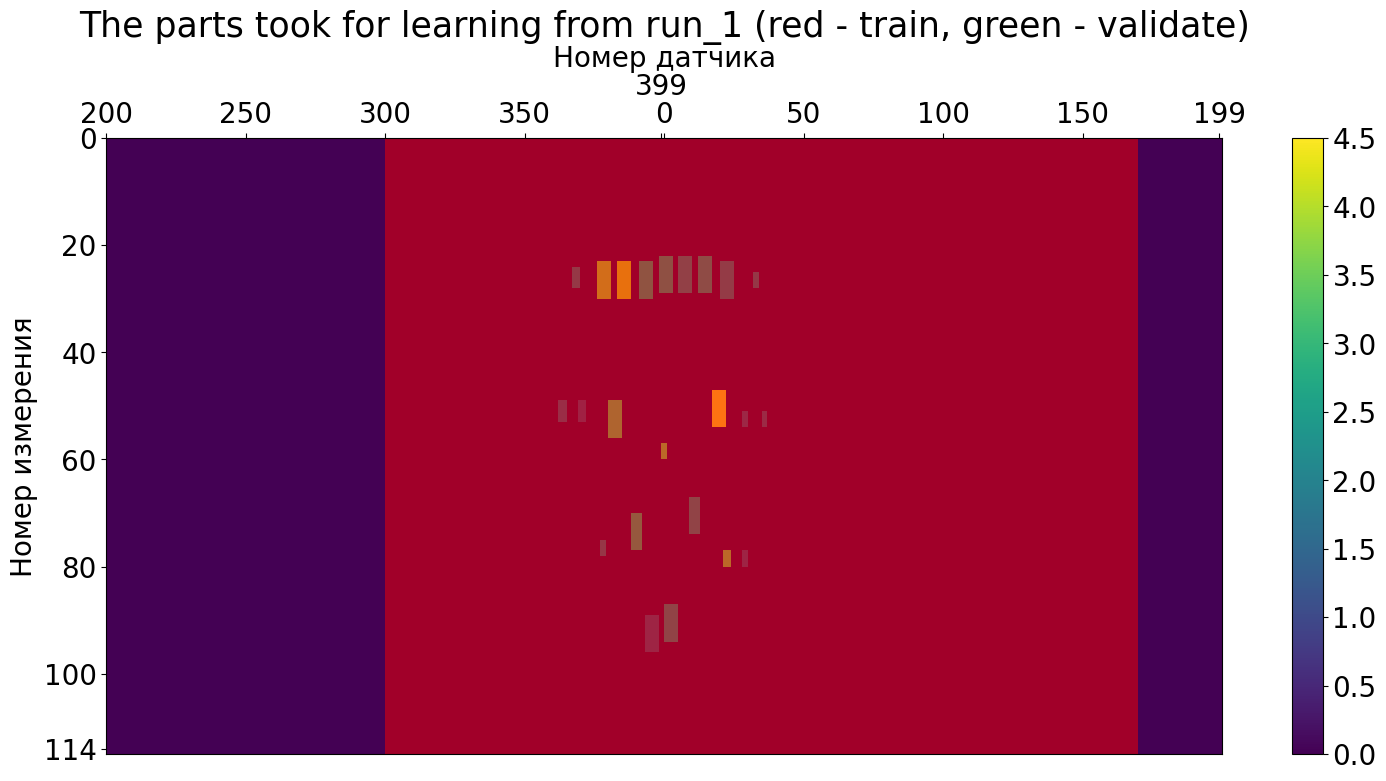

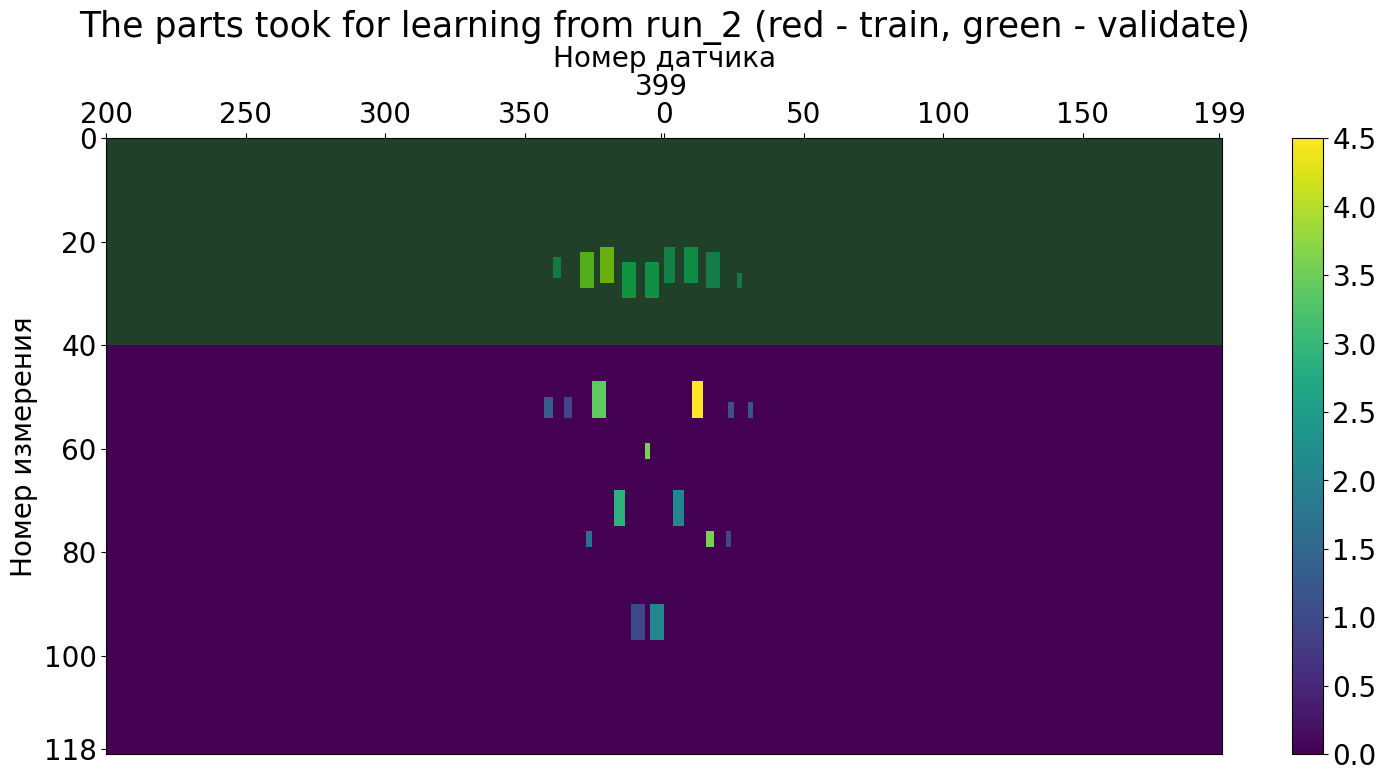

In [5]:
# show parts took for learning
x_df1, y_df1 = dw.get_x_and_y_data(*PATH_TO_DATA['run_1'])
x_df2, y_df2 = dw.get_x_and_y_data(*PATH_TO_DATA['run_2'])
x_df1 = x_df2 = None

y_df1 = dw.roll_df(y_df1, XSHIFT, 1)
y_df2 = dw.roll_df(y_df2, XSHIFT, 1)

train_run_1_rects = []
train_run_2_rects = []
val_run_1_rects = []
val_run_2_rects = []

for data_desc in train_dataset_desc:
    if data_desc.run_name == 'run_1':
        train_run_1_rects.append(Rectangle((data_desc.data_crop.left, data_desc.data_crop.top), 
                                           data_desc.data_crop.width, data_desc.data_crop.height, facecolor='red', alpha=0.5))
    else:
        train_run_2_rects.append(Rectangle((data_desc.data_crop.left, data_desc.data_crop.top), 
                                           data_desc.data_crop.width, data_desc.data_crop.height, facecolor='red', alpha=0.5))

for data_desc in val_dataset:
    if data_desc.run_name == 'run_1':
        val_run_1_rects.append(Rectangle((data_desc.data_crop.left, data_desc.data_crop.top), 
                                         data_desc.data_crop.width, data_desc.data_crop.height, facecolor='green', alpha=0.5))
    else:
        val_run_2_rects.append(Rectangle((data_desc.data_crop.left, data_desc.data_crop.top), 
                                         data_desc.data_crop.width, data_desc.data_crop.height, facecolor='green', alpha=0.5))


dw.draw_defects_map_with_rectangles_owerlap(y_df1, train_run_1_rects+val_run_1_rects, title = f'The parts took for learning from run_1 (red - train, green - validate)')
dw.draw_defects_map_with_rectangles_owerlap(y_df2, train_run_2_rects+val_run_2_rects, title = f'The parts took for learning from run_2 (red - train, green - validate)')

In [6]:
#### всякие константы для последующей работы

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.001 #0.0000002 # шаг сходимости back propogation
#CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
CMP_solver = keras.optimizers.SGD(CMP_learning_rate) # оптимизатор
CMP_loss_funcs = keras.losses.BinaryCrossentropy() #BinaryCrossentropy() 
CMP_metrics = [keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
               keras.metrics.MeanSquaredError(name='MeanSquaredError'),
               keras.metrics.TruePositives(name='TruePositives'),
               keras.metrics.FalsePositives(name='FalsePositives'),
               keras.metrics.TrueNegatives(name='TrueNegatives'),
               keras.metrics.FalseNegatives(name='FalseNegatives'),     
               keras.metrics.Precision(name='Precision'),
               keras.metrics.Recall(name='Recall'),
               keras.metrics.AUC(name='AUC')]
#///////////////////////////////// для колбэков

# для Early_stopping
ES_patience = 3 # кол-во эпох без улучшений
ES_min_delta = 0.00001 # минимальное улучшение параметра за cur_patience
ES_monitor_parametr =  'loss' # отслеживаемый параметр 
ES_save_best_weights = True # сохранять ли веса нейронки с лучшими результатами
Es_mode = 'max'

   # для ReduceLROnPlateau
RLPOP_monitor_parametr = 'loss'  # отслеживаемый параметр 
RLPOP_factor = 0.3 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
RLPOP_patience = 1 # кол-во эпох без улучшений
RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
RLPOP_min_delta = 0.001 # порог изменения отслеживаемого значения
RLPOP_cooldown = 2 # количество эпох до возобновления работы после изменения шага сходимости
RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 4 # размерpython concat lists bach при обучении/тестировании1
#FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 14 # количество эпох обучения
#FIT_validation_split = 0.10 #0.20 # процент валидационных данных, отсекаемых из тестовой выборки

2024-04-09 17:19:40.790591: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-09 17:19:40.821874: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-09 17:19:40.821931: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-09 17:19:40.823463: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-09 17:19:40.823534: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

In [7]:
#model = mv.get_model_v10(CROP_SIZE)
'''DROP = 0.1

def bnorm(layer, drop_percent):
    #return Dropout(drop_percent)(BatchNormalization()(layer))
    return Dropout(drop_percent)(layer)
    #return BatchNormalization()(layer)

augment_data = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(1),
  layers.RandomTranslation(0.4,0.4,fill_mode="reflect"),
  layers.RandomZoom(0.2,0.2,fill_mode="reflect")
])

input_data = Input((16,16,64), name = 'input_data')

aug_data = augment_data(input_data)

# 12
dconv_1_1 = Conv2D(64, (3,3), dilation_rate=(2, 2), activation='relu', name='dconv_1_1')(aug_data)

# 6
dconv_1_2 = Conv2D(64, (3,3), dilation_rate=(5, 5), activation='relu', name='dconv_1_2')(aug_data)
up_1_2 = UpSampling2D(2, interpolation='bilinear', name='up_1_2') (dconv_1_2)

# 4
dconv_1_3 = Conv2D(64, (3,3), dilation_rate=(6, 6), activation='relu', name='dconv_1_3')(aug_data)
up_1_3 = UpSampling2D(3, interpolation='bilinear', name='up_1_3') (dconv_1_3)

# 2
dconv_1_4 = Conv2D(64, (3,3), dilation_rate=(7, 7), activation='relu', name='dconv_1_4')(aug_data)
up_1_4 = UpSampling2D(6, interpolation='bilinear', name='up_1_4') (dconv_1_4)


conc_1_1 = concatenate([dconv_1_1, up_1_2, up_1_3, up_1_4],axis=3, name='conc_1_1')


conv_2_1 = Conv2D(256, (3,3), dilation_rate=(2, 2), activation='relu', padding='same', name='conv_2_1')(conc_1_1)
conv_2_2 = Conv2D(256, (3,3), dilation_rate=(2, 2), activation='relu', padding='same', name='conv_2_2')(conv_2_1)
conv_2_3 = Conv2D(256, (3,3), dilation_rate=(2, 2), activation='relu', padding='same', name='conv_2_3')(conv_2_2)
pool_2_1 = MaxPooling2D((2,2), strides=2, name='pool_2_1')(conv_2_3)

conv_2_4 = Conv2D(512, (2,2), activation='relu', name='conv_2_4')(pool_2_1)
conv_2_5 = Conv2D(512, (2,2), activation='relu', name='conv_2_5')(conv_2_4)
conv_2_6 = Conv2D(512, (2,2), activation='relu', name='conv_2_6')(conv_2_5)
conv_2_7 = Conv2D(512, (2,2), activation='relu', name='conv_2_7')(conv_2_6)
pool_2_2 = MaxPooling2D((2,2), strides=2, name='pool_2_2')(conv_2_7)

d_4_1 = Dense(256, activation='linear', name='d_4_1')(Flatten(name='flat_3_1')(pool_2_2))
d_4_2 = Dense(128, activation='linear', name='d_4_2')(d_4_1)
d_4_3 = Dense(64, activation='linear', name='d_4_3')(d_4_2)
d_4_4 = Dense(16, activation='linear', name='d_4_4')(d_4_3)
d_4_5 = Dense(4, activation='linear', name='d_4_5')(d_4_4)

output_def_bool = Dense(1, activation='sigmoid', name='output_def_bool')(d_4_5)
    
model = keras.Model([input_data], [output_def_bool], name='model')'''

model = keras.models.load_model('networks/CNN/id=v13n01_in(16x16x64)_out(1)_train=0dot0_test=0dot0.keras')

model.compile(optimizer=CMP_solver, loss=CMP_loss_funcs, metrics=CMP_metrics)

print(model.summary())

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_data          │ (None, 16, 16,    │          0 │ -                 │
│ (InputLayer)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 16, 16,    │          0 │ input_data[0][0]  │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_2 (Conv2D)  │ (None, 6, 6, 64)  │     36,928 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_3 (Conv2D)  │ (None, 4, 4, 64)  │     36,928 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_4 (Conv2D)  │ (None, 2, 2, 64)  │     36,928 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dconv_1_1 (Conv2D)  │ (None, 12, 12,    │     36,928 │ sequential[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_1_2              │ (None, 12, 12,    │          0 │ dconv_1_2[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_1_3              │ (None, 12, 12,    │          0 │ dconv_1_3[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_1_4              │ (None, 12, 12,    │          0 │ dconv_1_4[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conc_1_1            │ (None, 12, 12,    │          0 │ dconv_1_1[0][0],  │
│ (Concatenate)       │ 256)              │            │ up_1_2[0][0],     │
│                     │                   │            │ up_1_3[0][0],     │
│                     │                   │            │ up_1_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_1 (Conv2D)   │ (None, 12, 12,    │    590,080 │ conc_1_1[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_2 (Conv2D)   │ (None, 12, 12,    │    590,080 │ conv_2_1[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_3 (Conv2D)   │ (None, 12, 12,    │    590,080 │ conv_2_2[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_2_1            │ (None, 6, 6, 256) │          0 │ conv_2_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_4 (Conv2D)   │ (None, 5, 5, 512) │    524,800 │ pool_2_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_5 (Conv2D)   │ (None, 4, 4, 512) │  1,049,088 │ conv_2_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_6 (Conv2D)   │ (None, 3, 3, 512) │  1,049,088 │ conv_2_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_7 (Conv2D)   │ (None, 2, 2, 512) │  1,049,088 │ conv_2_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,763,609 (21.99 MB)

 Trainable params: 5,763,609 (21.99 MB)

 Non-trainable params: 0 (0.00 B)

None


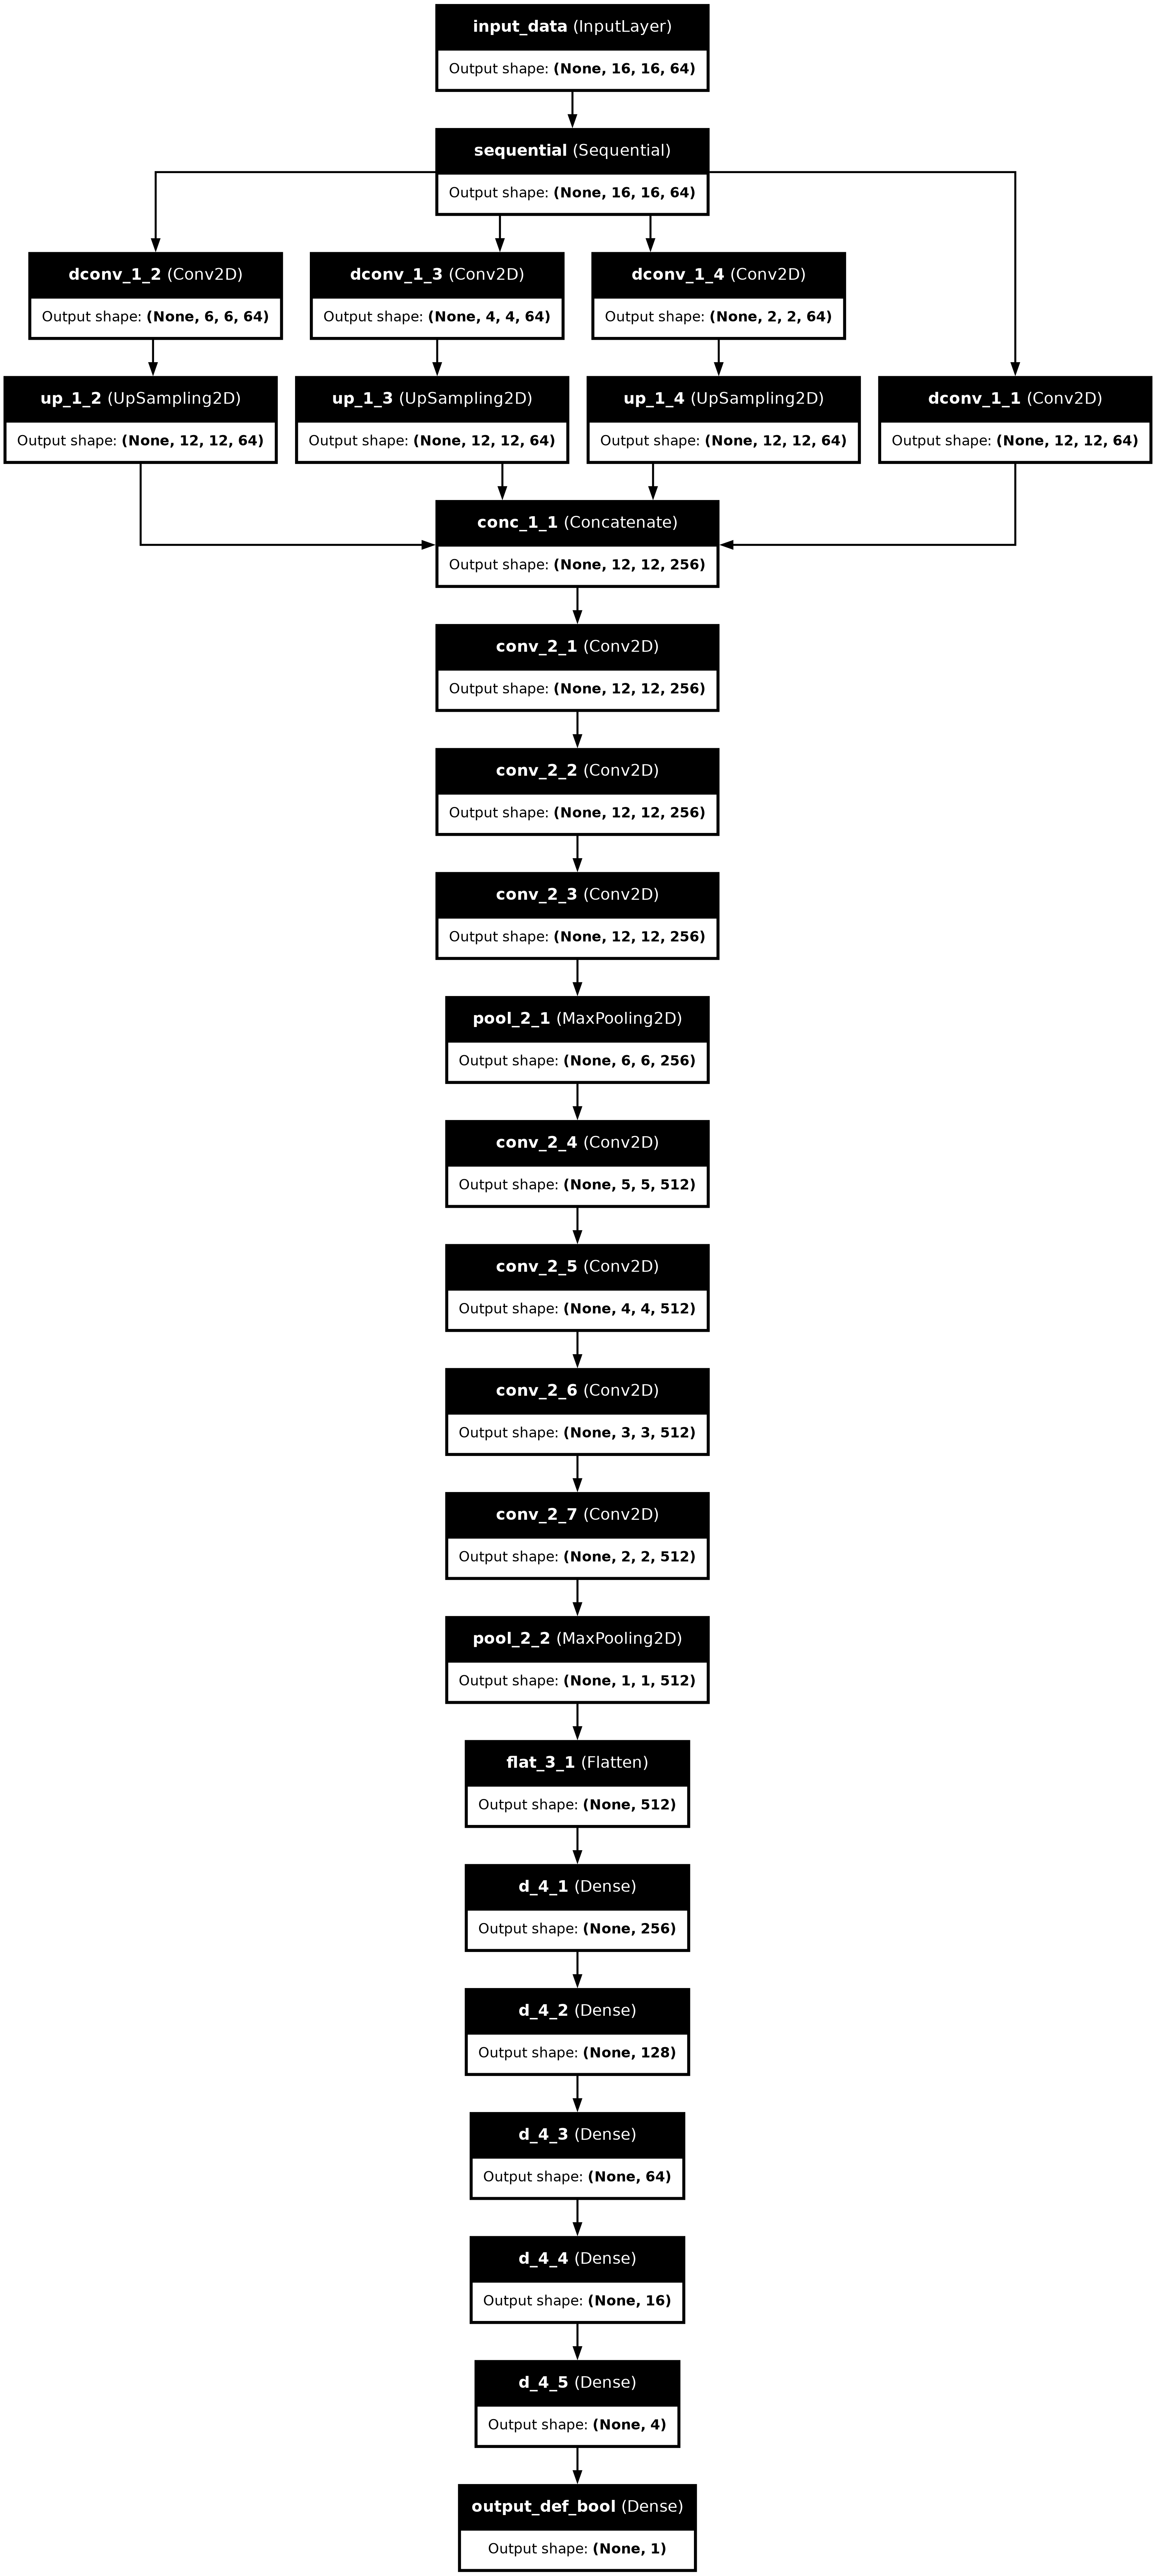

In [8]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False,
)

In [9]:
# Создание и настройка колбэков

callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

'''temp = keras.callbacks.EarlyStopping(
            monitor = ES_monitor_parametr, 
            min_delta = ES_min_delta, 
            patience = ES_patience,
            restore_best_weights = ES_save_best_weights
            )
callback_list.append(temp)'''

temp = keras.callbacks.ReduceLROnPlateau(
            monitor = RLPOP_monitor_parametr, 
            factor = RLPOP_factor, 
            patience = RLPOP_patience, 
            verbose = RLPOP_verbose,
            mode = RLPOP_mode, 
            min_delta = RLPOP_min_delta, 
            cooldown = RLPOP_cooldown, 
            min_lr = RLPOP_min_lr
            )
callback_list.append(temp)

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [10]:
history = model.fit(train_x, train_y_binary,
                    batch_size = FIT_batch_size, 
                    epochs = FIT_epochs, 
                    verbose = FIT_verbose, 
                    shuffle=True,
                    validation_data = (val_x, val_y_binary), 
                    callbacks = FIT_callback_list)

2024-04-09 17:19:42.949340: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1671168000 exceeds 10% of free system memory.
2024-04-09 17:19:44.376186: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1671168000 exceeds 10% of free system memory.


6375/6375 ━━━━━━━━━━━━━━━━━━━━ 104s 16ms/step - AUC: 0.8902 - BinaryAccuracy: 0.8398 - FalseNegatives: 1260.2693 - FalsePositives: 791.6570 - MeanSquaredError: 0.1050 - Precision: 0.6327 - Recall: 0.5036 - TrueNegatives: 9303.6299 - TruePositives: 1398.4429 - loss: 0.3194 - val_AUC: 0.9299 - val_BinaryAccuracy: 0.8793 - val_FalseNegatives: 967.0000 - val_FalsePositives: 195.0000 - val_MeanSquaredError: 0.0804 - val_Precision: 0.7295 - val_Recall: 0.3523 - val_TrueNegatives: 7937.0000 - val_TruePositives: 526.0000 - val_loss: 0.2629 - learning_rate: 0.0010
6375/6375 ━━━━━━━━━━━━━━━━━━━━ 99s 16ms/step - AUC: 0.9074 - BinaryAccuracy: 0.8562 - FalseNegatives: 1063.0836 - FalsePositives: 793.8243 - MeanSquaredError: 0.0973 - Precision: 0.6649 - Recall: 0.5916 - TrueNegatives: 9301.4629 - TruePositives: 1595.6287 - loss: 0.2976 - val_AUC: 0.9335 - val_BinaryAccuracy: 0.8785 - val_FalseNegatives: 1068.0000 - val_FalsePositives: 101.0000 - val_MeanSquaredError: 0.0807 - val_Precision: 0.8080 -

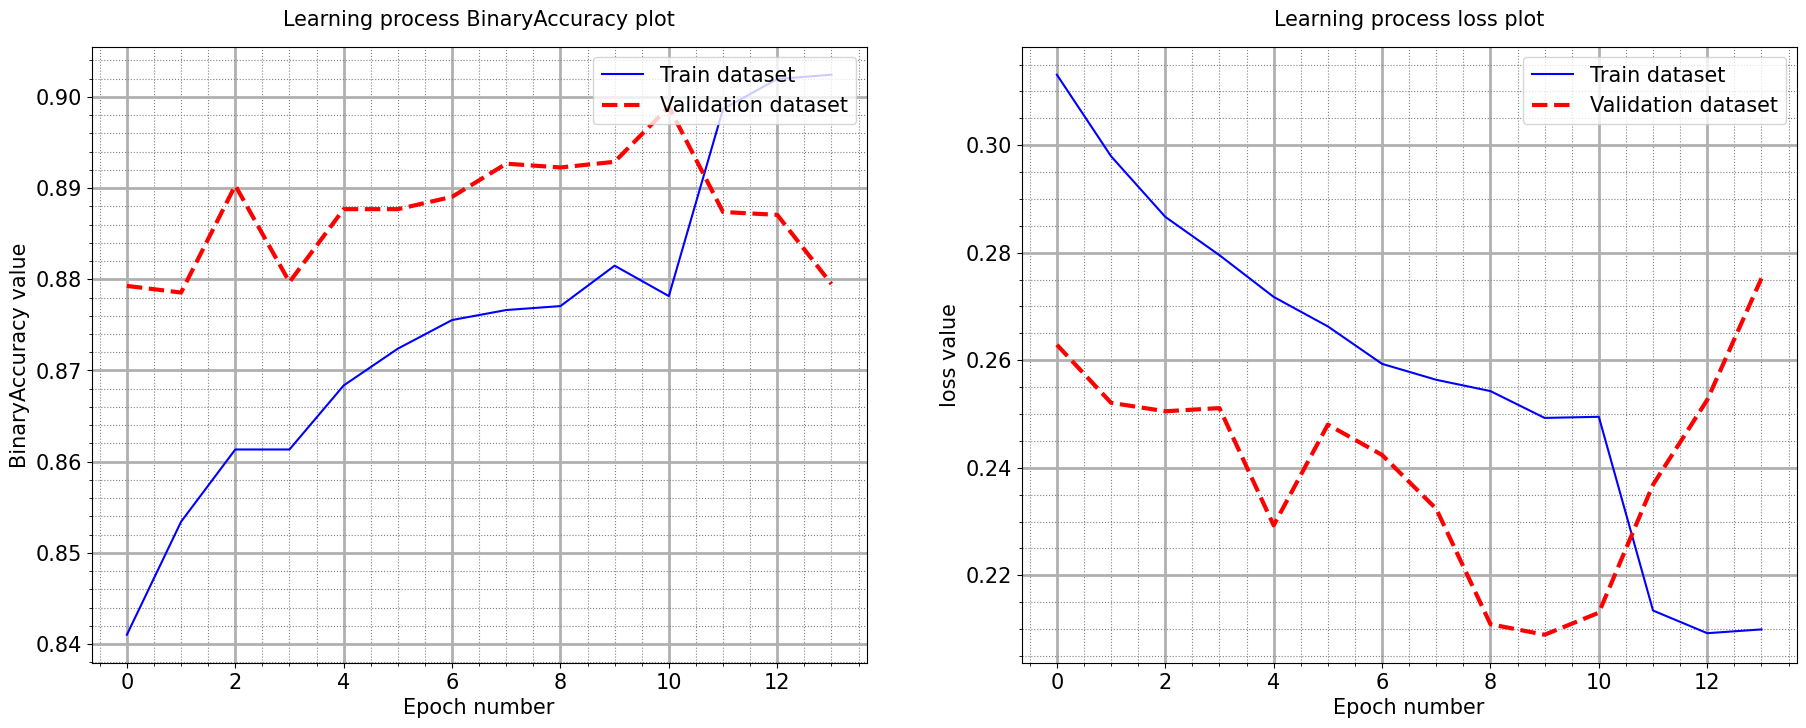

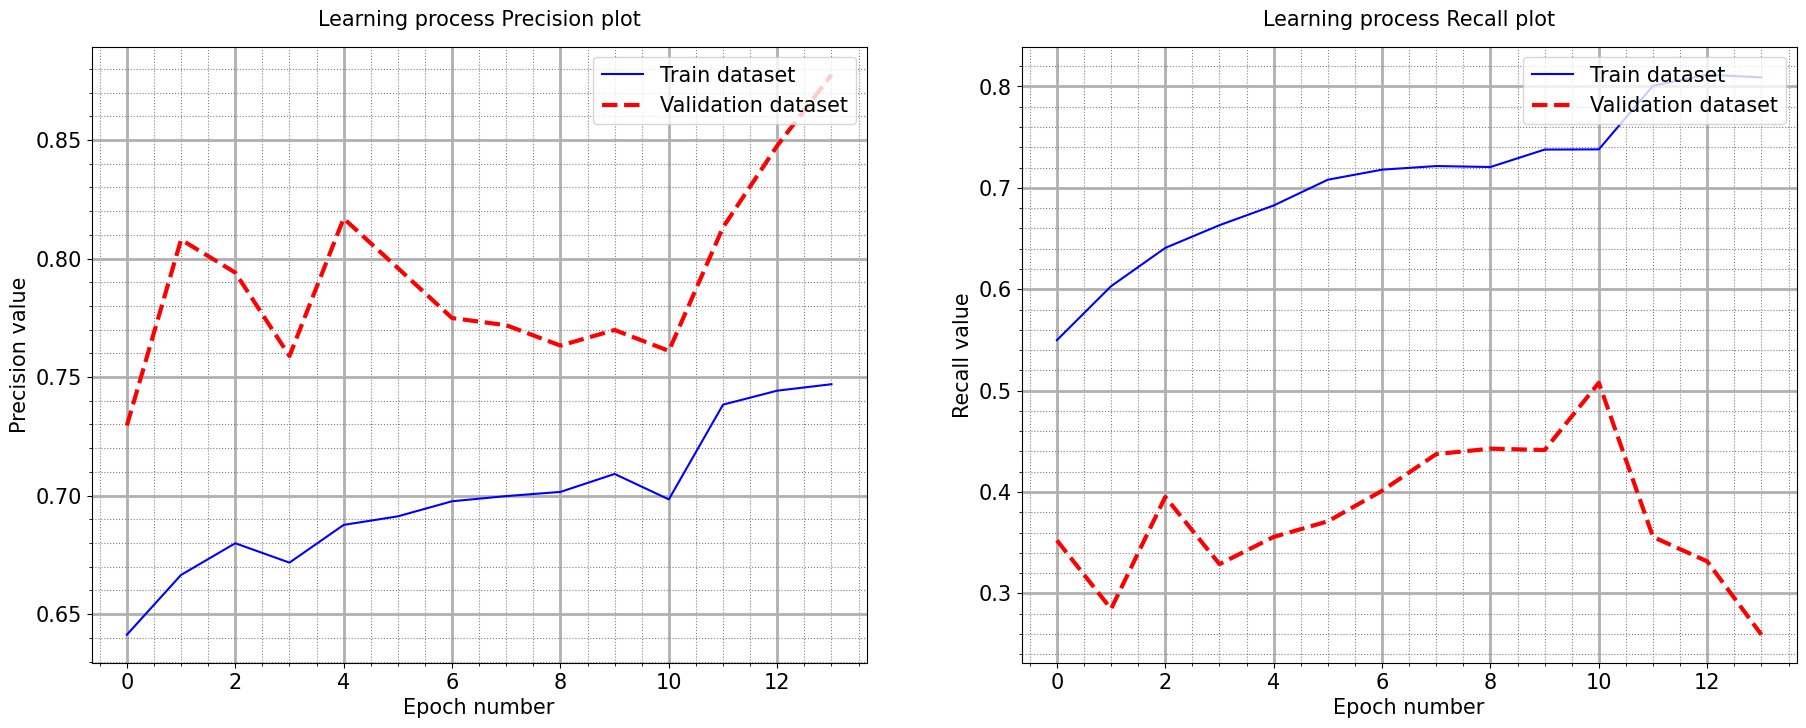

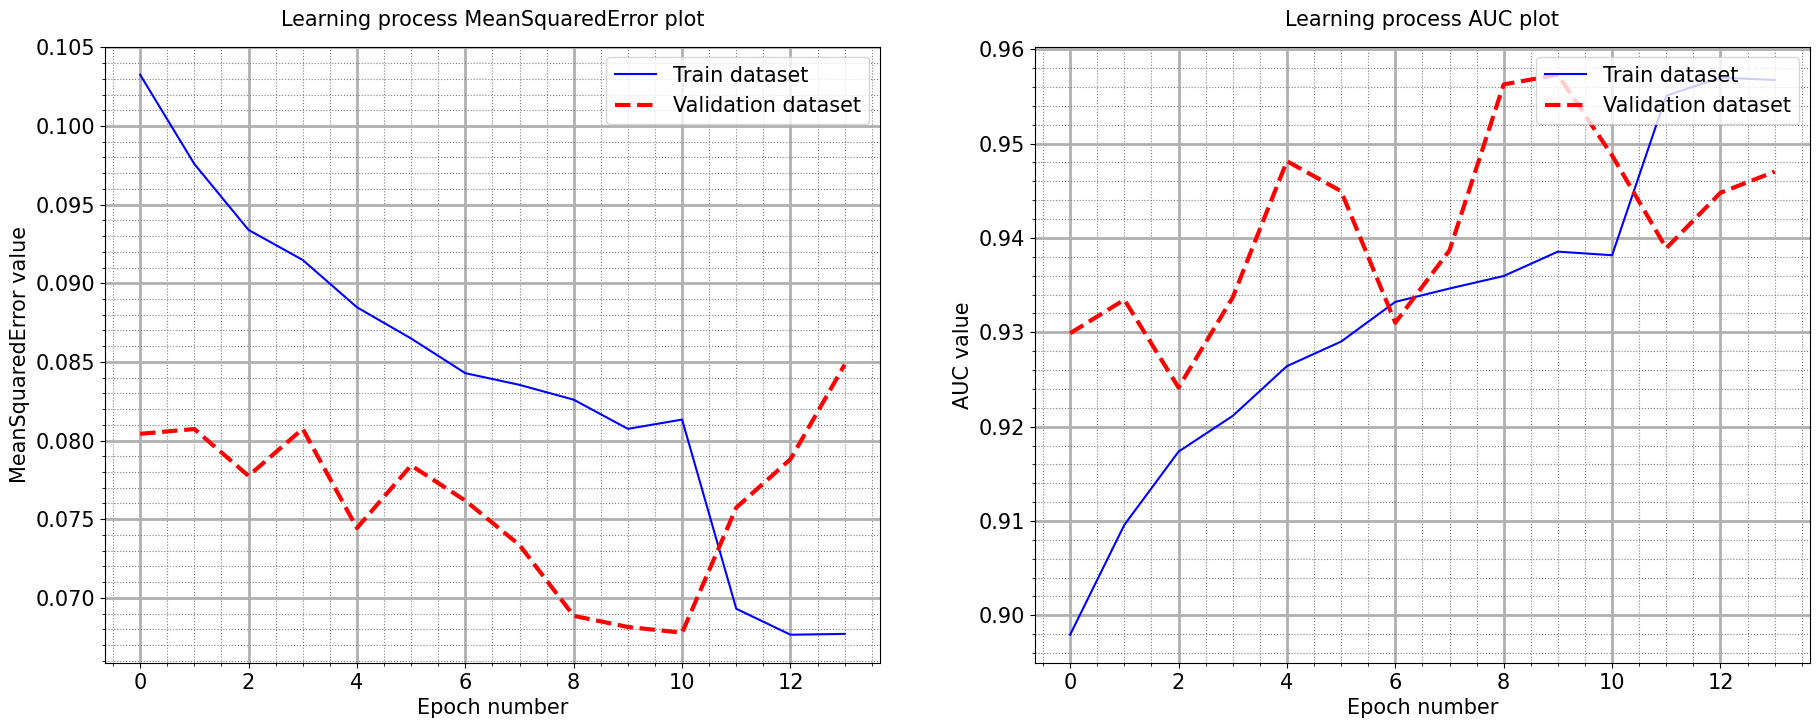

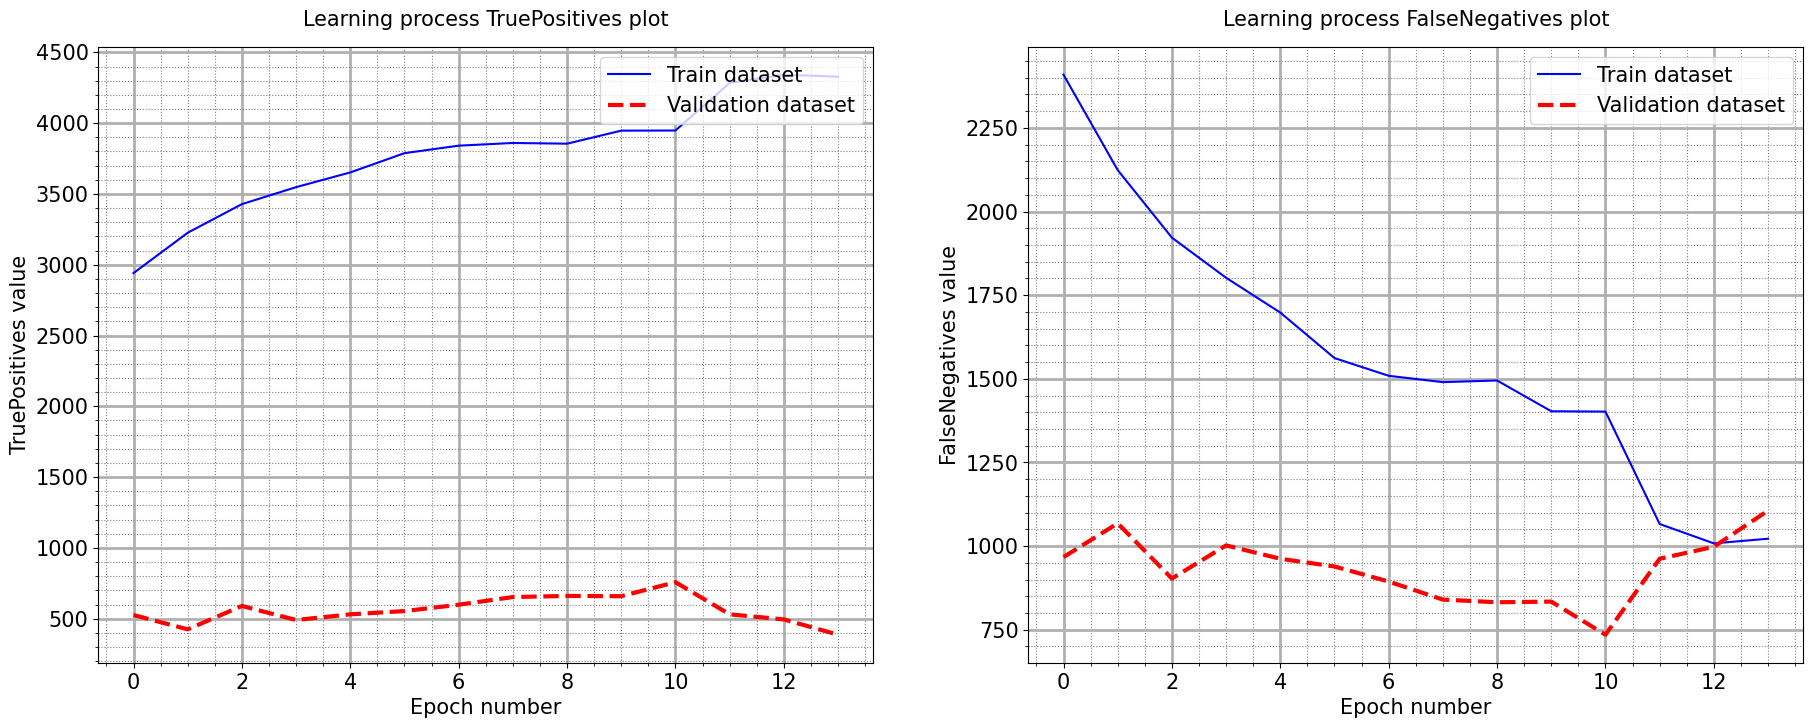

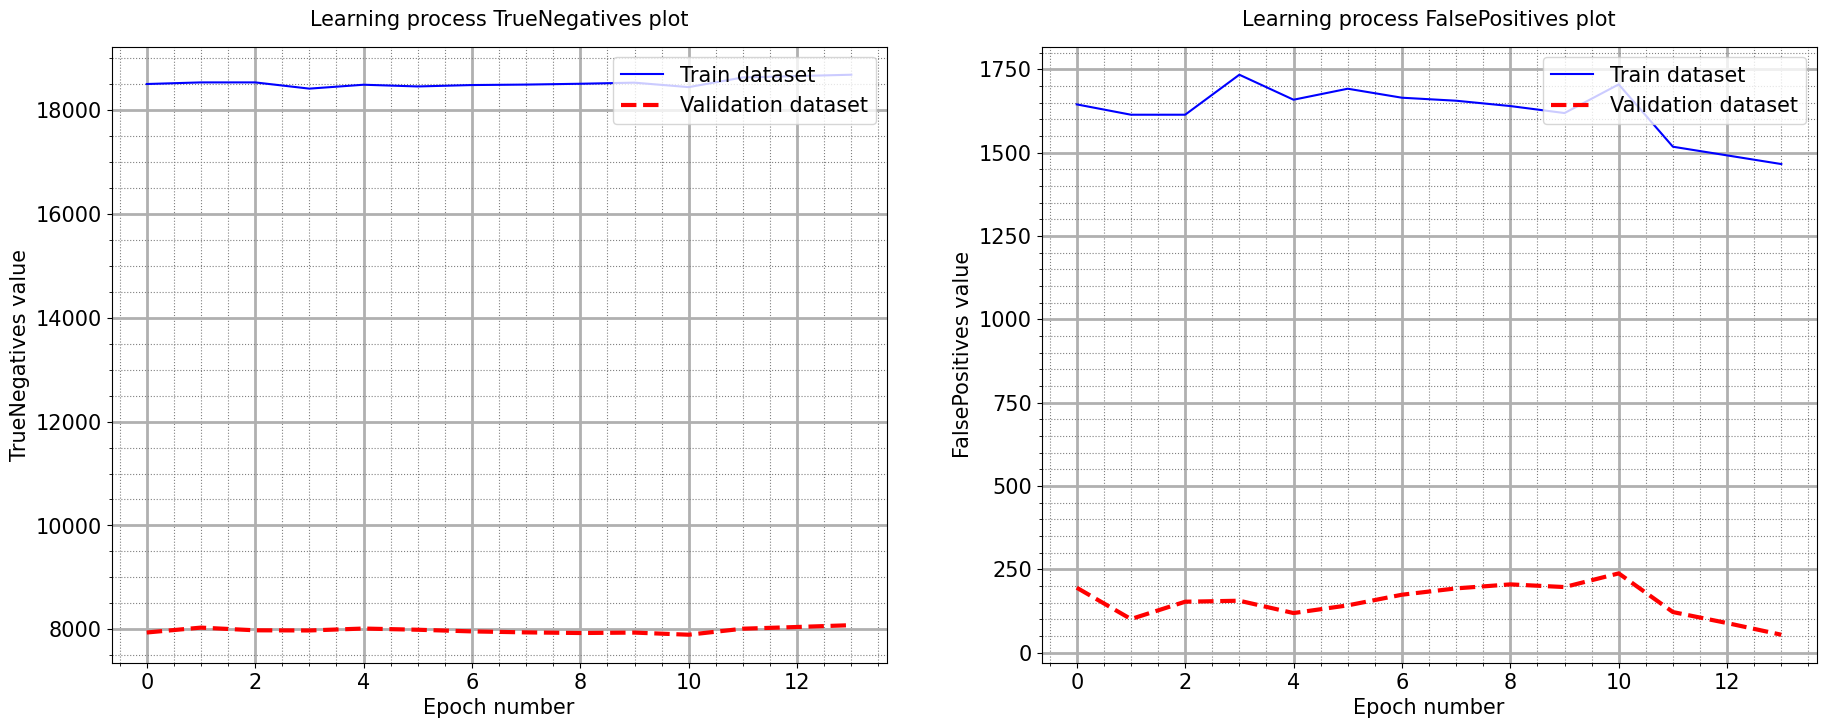

In [11]:
FONT_SIZE = 15
for key1,key2 in zip(['BinaryAccuracy','Precision','MeanSquaredError','TruePositives','TrueNegatives'],
                     ['loss','Recall','AUC','FalseNegatives','FalsePositives']):
    fig, axes = plt.subplots(1,2)

    fig.set_figwidth(22)
    fig.set_figheight(8)
    
    axes[0].plot(history.history[key1], 
             label='Train dataset',  linewidth=1.5, color='blue')
    axes[0].plot(history.history[f'val_{key1}'], linestyle = '--', 
             label='Validation dataset',  linewidth=3, color='red')
    axes[0].set_xlabel('Epoch number', fontsize=FONT_SIZE)
    axes[0].set_ylabel(f'{key1} value', fontsize=FONT_SIZE)
    axes[0].set_title(f"Learning process {key1} plot", fontsize=FONT_SIZE, pad=15)
    axes[0].tick_params(axis='both', which='both', labelsize = FONT_SIZE)
    axes[0].minorticks_on()
    axes[0].grid(which='major', linewidth=2)
    axes[0].grid(which='minor', color = 'gray', linestyle = ':')
    axes[0].legend(fontsize = FONT_SIZE, facecolor = "white", loc = 'upper right')

    axes[1].plot(history.history[key2], 
             label='Train dataset',  linewidth=1.5, color='blue')
    axes[1].plot(history.history[f'val_{key2}'], linestyle = '--', 
             label='Validation dataset',  linewidth=3, color='red')
    axes[1].set_xlabel('Epoch number', fontsize=FONT_SIZE)
    axes[1].set_ylabel(f'{key2} value', fontsize=FONT_SIZE)
    axes[1].set_title(f"Learning process {key2} plot", fontsize=FONT_SIZE, pad=15)
    axes[1].tick_params(axis='both', which='both', labelsize = FONT_SIZE)
    axes[1].minorticks_on()
    axes[1].grid(which='major', linewidth=2)
    axes[1].grid(which='minor', color = 'gray', linestyle = ':')
    axes[1].legend(fontsize = FONT_SIZE, facecolor = "white", loc = 'upper right')

    plt.show()

In [12]:
'''FONT_SIZE = 15
for key in [k for k in history.history.keys() if not k.startswith('val')]:
    fig, ax = plt.subplots()

    fig.set_figwidth(12)
    fig.set_figheight(8)
    
    plt.plot(history.history[key], 
             label='Train dataset',  linewidth=1.5, color='blue')
    plt.plot(history.history[f'val_{key}'], linestyle = '--', 
             label='Validation dataset',  linewidth=3, color='red')
    
    ax.set_xlabel('Epoch number', fontsize=FONT_SIZE)
    ax.set_ylabel(f'{key} value', fontsize=FONT_SIZE)
    ax.set_title(f"Learning process {key} plot", fontsize=FONT_SIZE, pad=15)
    
    ax.patch.set_alpha(0)
    
    #  Устанавливаем форматирование делений:
    ax.tick_params(axis='both', which='both', labelsize = FONT_SIZE)
    
    # Вывод и настройка сетки
    ax.minorticks_on()
    ax.grid(which='major', linewidth=2)
    ax.grid(which='minor', color = 'gray', linestyle = ':')
    
    ax.legend(fontsize = FONT_SIZE, facecolor = "white", loc = 'upper right')
    
    plt.show()'''

'FONT_SIZE = 15\nfor key in [k for k in history.history.keys() if not k.startswith(\'val\')]:\n    fig, ax = plt.subplots()\n\n    fig.set_figwidth(12)\n    fig.set_figheight(8)\n    \n    plt.plot(history.history[key], \n             label=\'Train dataset\',  linewidth=1.5, color=\'blue\')\n    plt.plot(history.history[f\'val_{key}\'], linestyle = \'--\', \n             label=\'Validation dataset\',  linewidth=3, color=\'red\')\n    \n    ax.set_xlabel(\'Epoch number\', fontsize=FONT_SIZE)\n    ax.set_ylabel(f\'{key} value\', fontsize=FONT_SIZE)\n    ax.set_title(f"Learning process {key} plot", fontsize=FONT_SIZE, pad=15)\n    \n    ax.patch.set_alpha(0)\n    \n    #  Устанавливаем форматирование делений:\n    ax.tick_params(axis=\'both\', which=\'both\', labelsize = FONT_SIZE)\n    \n    # Вывод и настройка сетки\n    ax.minorticks_on()\n    ax.grid(which=\'major\', linewidth=2)\n    ax.grid(which=\'minor\', color = \'gray\', linestyle = \':\')\n    \n    ax.legend(fontsize = FONT_SI

In [13]:
# сохранение модели в файл
model.save(f"networks/CNN/id=v13n02_in({CROP_SIZE}x{CROP_SIZE}x64)_out(1)_train=0dot0_test=0dot0.keras")

#### 